In [455]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [456]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, mutation_scale=20, arrowstyle='-|>', shrinkA=0, shrinkB=0, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs, arrowstyle=arrowstyle, shrinkA=shrinkA, shrinkB=shrinkB, mutation_scale=mutation_scale)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

# NiPS3

In [457]:
p = glob("../figures/crystal structures/NiPS3*/POSCAR")[0]

text = open(p).read().split("\n")

structure = np.array([[float(j) for j in i[1:].split("   ")] for i in text[2:5]])

# extract positions
atoms = list(groupby_list(text[8:-1], lambda x: x.split(" ")[-1]))
positions = {}
for atom, text in atoms:
    positions[atom] = np.array([
        [float(j) for j in " ".join(i[3:].split(" ")[:-1]).split("    ")]
        for i in text
    ])

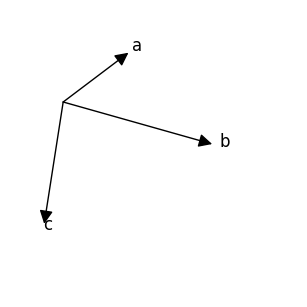

In [458]:
zero = np.array([0, 0, 0])
ax = plt.figure().add_subplot(projection='3d')
for vec, n in zip(structure, ["a", "b", "c"]):
    # v = vec / np.linalg.norm(vec)
    v = vec
    a = Arrow3D(*np.transpose([zero, v]), color="k")
    ax.add_artist(a)
    ax.plot(*np.transpose([zero, v]), alpha=0)
    ax.text(*v*1.05, n)
ax.set_axis_off()
plt.show()

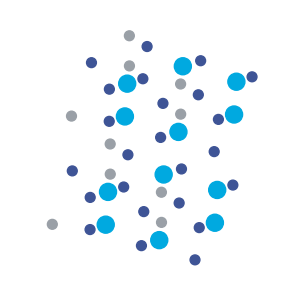

In [466]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect('equal')
ax.set_axis_off()

# draw atoms
grid = np.array([[i, j, k] for i in range(2) for j in range(1) for k in range(3)])
for elm, pos in positions.items():
    pos_grid = [pos + v for v in grid]
    pos_grid = np.array(pos_grid).reshape(-1, 3)
    pos_grid = pos_grid[(pos_grid[:, 2] > .5) & (pos_grid[:, 2] <2.5)]
    pos_grid = pos_grid[(pos_grid[:, 0] < 1.2)]
    pos_grid = np.array([np.dot(i, structure) for i in pos_grid]) # apply the structure
    s = 50
    if "Ni" in elm: s = 150
    
    ax.scatter(*np.transpose(pos_grid), "o", s=s, alpha=1, label=elm)
    
# calculate the grid
atoms = {}
for elm, pos in positions.items():
    pos_grid = [pos + v for v in grid]
    pos_grid = np.array(pos_grid).reshape(-1, 3)
    pos_grid = pos_grid[(pos_grid[:, 2] > .5) & (pos_grid[:, 2] <2.5)]
    pos_grid = pos_grid[(pos_grid[:, 0] < 1.2)]
    pos_grid = np.array([np.dot(i, structure) for i in pos_grid]) # apply the structure
    atoms[elm] = pos_grid
    
bonds_per_atom = {
    'Ni2+': 6,
    "P4+": 4,
    "S2-": 2
}
# find the n nearest neighbors



In [465]:
atoms.keys()

dict_keys(['Ni2+', 'P4+', 'S2-'])

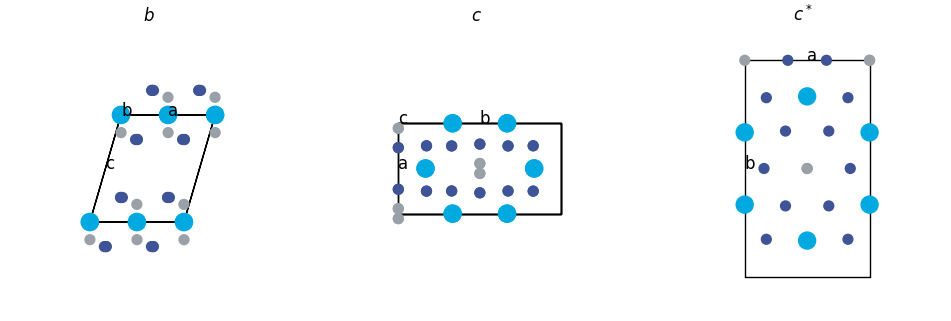

In [452]:
def plot_unit_cell(ax, structure, positions, cell=True, top=2.5):
    ax.set_proj_type('ortho')
    ax.set_aspect('equal')
    ax.set_axis_off()
    
    # draw atoms
    grid = np.array([[i, j, k] for i in range(2) for j in range(1) for k in range(3)])
    for elm, pos in positions.items():
        pos_grid = [pos + v for v in grid]
        pos_grid = np.array(pos_grid).reshape(-1, 3)
        pos_grid = pos_grid[(pos_grid[:, 2] > .5) & (pos_grid[:, 2] <top)]
        pos_grid = pos_grid[(pos_grid[:, 0] < 1.2)]
        pos_grid = np.array([np.dot(i, structure) for i in pos_grid]) # apply the structure
        s = 50
        if "Ni" in elm: s = 150
        
        ax.scatter(*np.transpose(pos_grid), "o", s=s, alpha=1, label=elm)
        
    # draw unit cell
    if cell:
        cell = np.array([
            [0, 0, 0],
            [0, 1, 0],
            [1, 1, 0],
            [1, 0, 0],
            [0, 0, 0],
            [0, 0, 1],
            [0, 1, 1],
            [1, 1, 1],
            [1, 0, 1],
            [0, 0, 1],
            [0, 1, 1],
            [0, 1, 0],
            [1, 1, 0],
            [1, 1, 1],
            [1, 0, 1],
            [1, 0, 0] 
        ]) + np.array([0, 0, 1])
        ax.plot(*np.transpose(np.dot(cell, structure)), "k")
        for c, n in zip(structure, ["a", "b", "c"]):
            ax.text(*c/2 + structure[-1], n, zorder=10)
    
def set_view_vector(ax, v):
    ax.set_aspect('equal')
    ax.view_init(
        elev = np.arctan2(v[2], np.linalg.norm(v[:-1])) * 180 / np.pi,
        azim = np.arctan2(v[1], v[0]) * 180 / np.pi,
    )
    
# plot the atom positions
fig, ax = plt.subplots(1, 3, subplot_kw={'projection':'3d'}, figsize=FIGSIZE_WIDE)

plot_unit_cell(ax[0], structure, positions)
set_view_vector(ax[0], structure[1])
ax[0].set_title("$b$")

plot_unit_cell(ax[1], structure, positions)
set_view_vector(ax[1], structure[2])
ax[1].set_title("$c$")

plot_unit_cell(ax[2], structure, positions, top=1.5, cell=False)
cell = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [1, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
]) + np.array([0, 0, 1])
ax[2].plot(*np.transpose(np.dot(cell, structure)), "k")
for c, n in zip(structure, ["a", "b"]):
    ax[2].text(*c/2 + structure[-1], n, zorder=10)
set_view_vector(ax[2], [0, 0, 1])
ax[2].set_title("$c^*$")

# plt.legend()
fig.tight_layout()
plt.show()